In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import math
import os
%matplotlib inline

# 1. Camera Calibration

1.1 Camera Parameters Extraction

In [67]:
# Define a class to receive the characteristics of each line detection
class LaneFinder():
    def __init__(self):
        self.last_left = None
        self.last_right = None
        self.left_fit = None
        self.right_fit = None
        
        self.last_leftx = None
        self.last_lefty = None
        self.last_rightx = None
        self.last_righty = None
        
        self.counter = 0
        self.reset_counter = 0
        
        self.slopes = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
        self.slope_counter=0
        self.curvyPath = False
        
lane = LaneFinder()

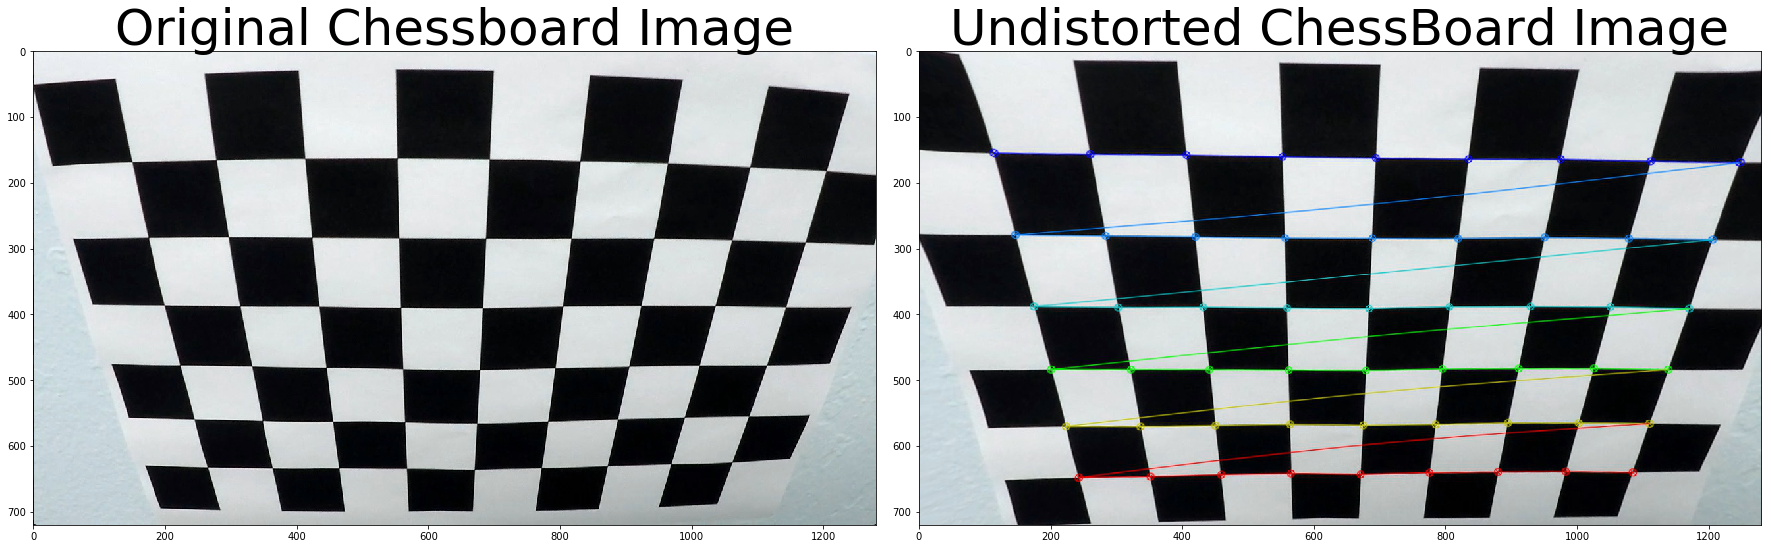

In [5]:
#Camera Calibration Images has 9x6 ChessBoard Images
# preparing object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
images_Calibratable = []
#Store Cal images with Corners Marked
counter=0
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        images_Calibratable.append(img)
        img_undistort_size = (img.shape[1], img.shape[0])
        counter =counter +1
        # Do camera calibration given object points and image points
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_undistort_size,None,None)        
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        cv2.imwrite('output_images/ChessBoard_Undistorted_Outputs/chessboard_undist'+ str(counter)+'.jpg',dst)
        
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.imread(images[1]))
ax1.set_title('Original Chessboard Image', fontsize=50)
ax2.imshow(cv2.imread('output_images/ChessBoard_Undistorted_Outputs/chessboard_undist2.jpg'))
ax2.set_title('Undistorted ChessBoard Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

1.2 Undistort Images

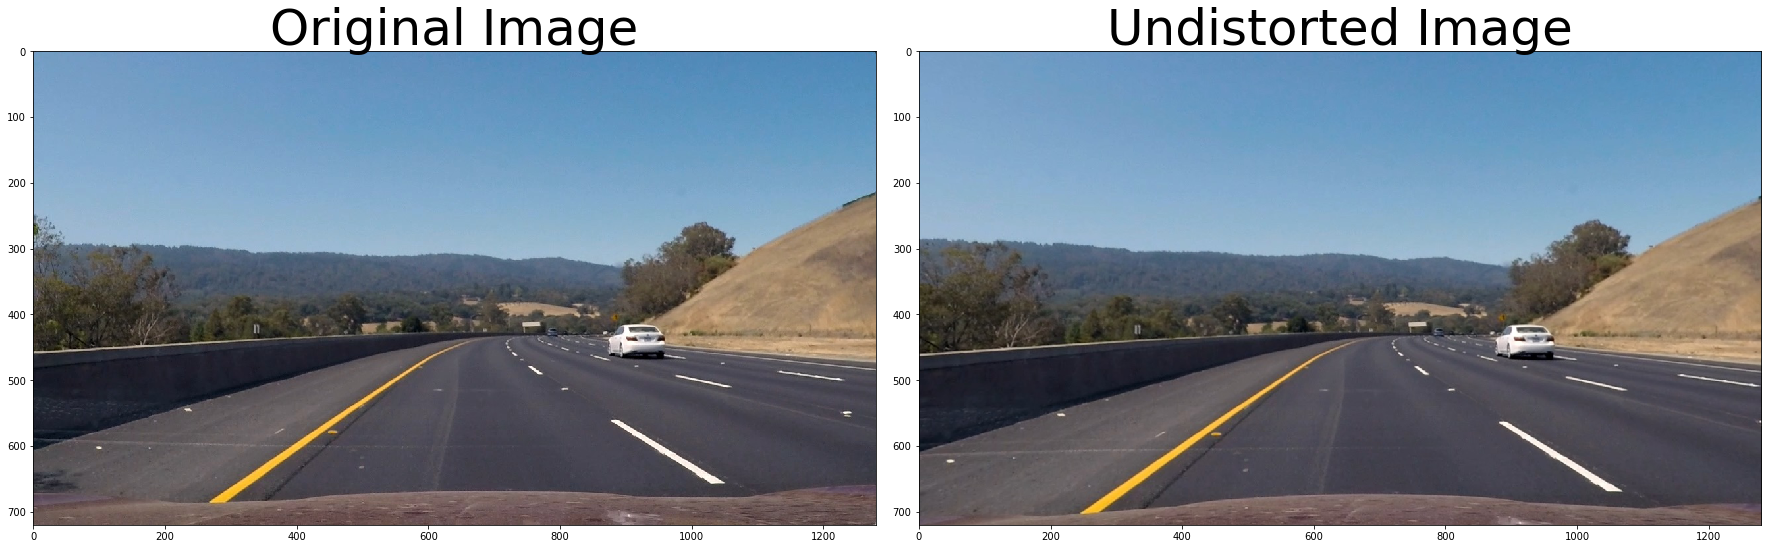

In [149]:
def undistort_image(input_image,save_image = "False", project_id=1 ):
    input_img_size = (input_image.shape[1], input_image.shape[0])
    #Calibrating the Camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, input_img_size,None,None)
    # Undistorting Test Image
    undistort_in = cv2.undistort(input_image, mtx, dist, None, mtx)
    if(save_image=="True"):
        if(project_id==1):
            cv2.imwrite('output_images/Project_Video_Outputs/Undistorted_test1.jpg',undistort_in)
        elif(project_id==2):
            cv2.imwrite('output_images/Challenge_Video_Outputs/Undistorted_test1.jpg',undistort_in)
        else:
            cv2.imwrite('output_images/Harder_Challenge_Video_Outputs/Undistorted_test1.jpg',undistort_in)
    return undistort_in

image1 = mpimg.imread('test_images/test3.jpg')
image2 = mpimg.imread('test_images/test_challenge_images1.jpg')
image3 = mpimg.imread('test_images/test_harder_challenge_images1.jpg')
test_image_output = undistort_image(image1,save_image= "False",project_id=1)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image1)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(test_image_output)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# 2. Pipeline (Test Images)


2.1  Color and Sobel thresholds

In [93]:
def color_Sobel_thresholder(img, s_thresh=(70, 255),r_thresh=(180, 255),h_thresh=(15,100), x_thresh=(20, 100),y_thresh=(20, 100), sx_dir=(0.7, 1.3),mag_thresh=(20,100),save_image ="False",project_id =1):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    R = img[:,:,0]
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    
    avg_brigthness_Half = int(avg_brightness(img[int(img.shape[0]/2):,:]))
    #print("brithness",avg_brigthness_Half)
    
    brightness_coef = (avg_brigthness_Half-40)/100
    # Sobel x Threshold
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel_x = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    xbinary = np.zeros_like(scaled_sobel_x)
    xbinary[(scaled_sobel_x >= int(x_thresh[0]*brightness_coef)) & (scaled_sobel_x <= x_thresh[1])] = 1    
    
    # Sobel y Threshold
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    abs_sobely = np.absolute(sobely) # Absolute y derivative to accentuate lines away from horizontal
    scaled_sobel_y = np.uint8(255*abs_sobely/np.max(abs_sobely))    
    ybinary = np.zeros_like(scaled_sobel_y)
    ybinary[(scaled_sobel_y >= int(y_thresh[0]*brightness_coef)) & (scaled_sobel_y <= y_thresh[1])] = 1 
    
    
    # Sobel Direction : Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= sx_dir[0]) & (absgraddir <= sx_dir[1])] = 1

    # Sobel Magnitude 
    magnitude = np.sqrt(np.square(sobelx)+np.square(sobely))
    abs_magnitude = np.absolute(magnitude)
    scaled_magnitude = np.uint8(255*abs_magnitude/np.max(abs_magnitude))
    mag_binary = np.zeros_like(scaled_magnitude)
    mag_binary[(scaled_magnitude >= int(mag_thresh[0]*brightness_coef)) & (scaled_magnitude <= mag_thresh[1])] = 1
    
    # Threshold S color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold R color channel
    r_binary = np.zeros_like(R)
    r_binary[(R >= r_thresh[0]) & (R <= r_thresh[1])] = 1  
    
    # Threshold H color channel
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    
    # Stack each binary Images together
    combined = np.zeros_like(dir_binary)
    
    #else case is for low light areas
    if(avg_brigthness_Half>70):
        combined[((xbinary == 1) & (ybinary == 1) | ((mag_binary == 1)) | (dir_binary == 1)) &((s_binary == 1)&(h_binary==1)|(r_binary==1))] = 1  
    #combined[((binary == 1)&(dir_binary==1)&(s_binary==1)|(h_binary==1))] = 1  
    else:
        combined[(xbinary == 1)&(ybinary==1)&(dir_binary==1)&(mag_binary == 1)] = 1
    
    if(save_image=="True"):
        if(project_id==1):
            cv2.imwrite('output_images/Project_Video_Outputs/Thresholded_Binary_test1.jpg',combined)
        elif(project_id==2):
            cv2.imwrite('output_images/Challenge_Video_Outputs/Thresholded_Binary_test1.jpg',combined)
        else:
            cv2.imwrite('output_images/Harder_Challenge_Video_Outputs/Thresholded_Binary_test1.jpg',combined)
    
    return combined

In [10]:
def avg_brightness(rgb_image):
    
    # Convert image to HSV
    hsv = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
    # Add up all the pixel values in the V channel
    sum_brightness = np.sum(hsv[:,:,2])    
    ## Calculated the average brightness 
    avg = sum_brightness/(rgb_image.shape[0]*rgb_image.shape[1])    
    return avg 

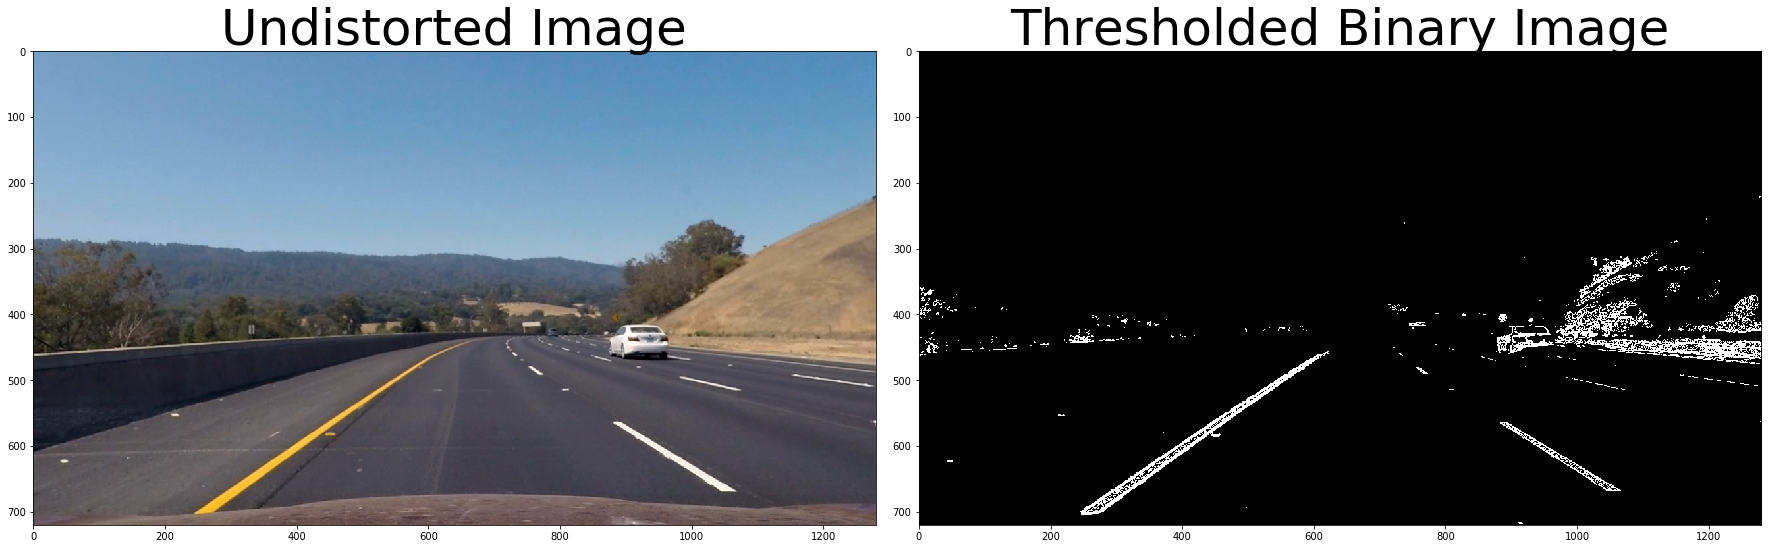

In [150]:
Thresholded_Binary = color_Sobel_thresholder(test_image_output,save_image= "False",project_id=1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image_output)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(Thresholded_Binary,cmap='gray')
ax2.set_title('Thresholded Binary Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# 2.2  Perspective Transform (Warping of image)

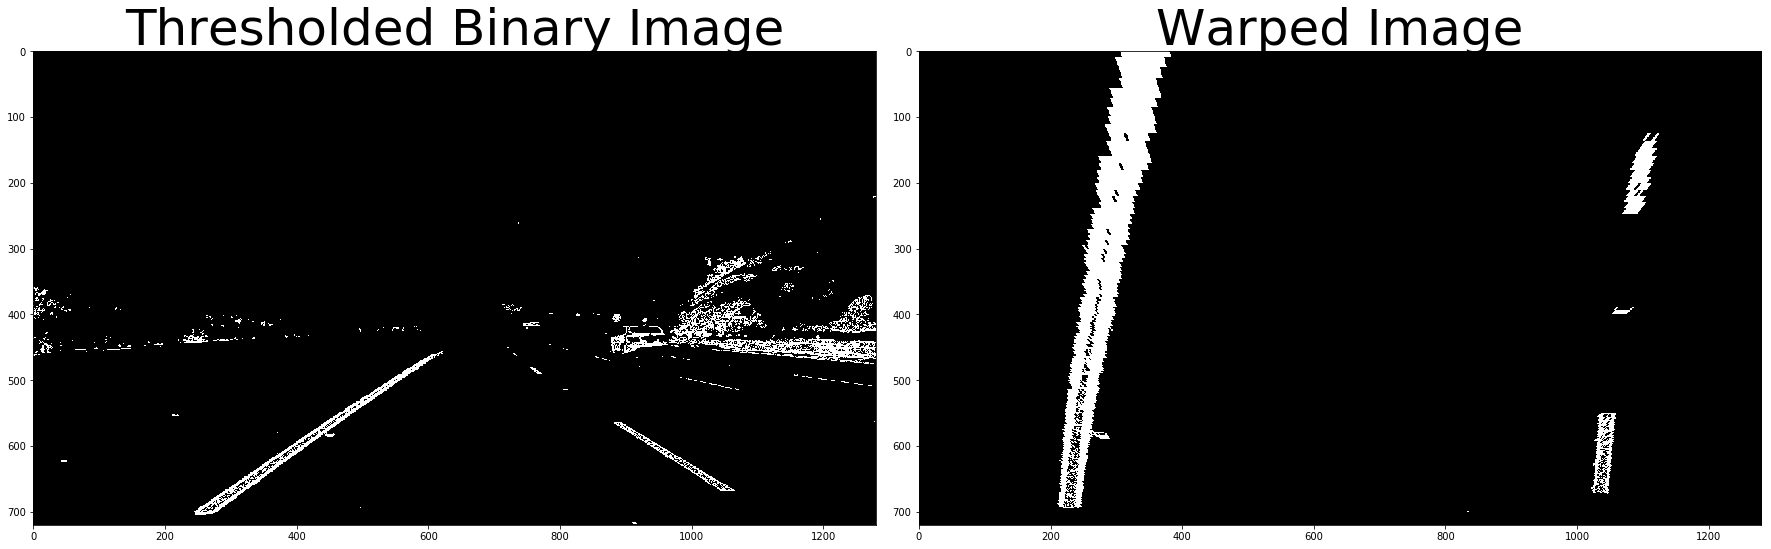

In [151]:
def transform_image(img,save_image = "False",project_id=1): 
    offset = 100 # offset for dst points
    
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    #print(img_size)
    leftupperpoint  = [568,470]
    rightupperpoint = [717,470]
    leftlowerpoint  = [260,680]
    rightlowerpoint = [1043,680]
    src = np.float32([leftupperpoint, leftlowerpoint, rightupperpoint, rightlowerpoint])
    dst = np.float32([[200,0], [200,680], [1000,0], [1000,680]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)
    if(save_image=="True"):
        if(project_id==1):
            cv2.imwrite('output_images/Project_Video_Outputs/Warped_image_test1.jpg',255*warped)
        elif(project_id==2):
            cv2.imwrite('output_images/Challenge_Video_Outputs/Warped_image_test1.jpg',255*warped)
        else:
            cv2.imwrite('output_images/Harder_Challenge_Video_Outputs/Warped_image_test1.jpg',255*warped)    
    return warped, M


warped_img, M = transform_image(Thresholded_Binary,save_image= "False",project_id=1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(Thresholded_Binary, cmap='gray')
ax1.set_title('Thresholded Binary Image', fontsize=50)
ax2.imshow(warped_img,cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



2.3 Finding Lane

In [147]:
def locate_lines(binary_warped, nwindows = 9, margin = 100, minpix = 50):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    #Local storage of Last Calculated current values
    last_iteration_current_leftx=0
    last_iteration_current_rightx=0

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
 
        #This check is for condition having excessive curve which might end up in lanes outside frame
        if((lane.curvyPath=="True") and ((abs(leftx_current - last_iteration_current_leftx)<5) or (abs(last_iteration_current_rightx - rightx_current)<5))) and lane.counter!=0:
            break
        else:
            last_iteration_current_leftx = leftx_current
            last_iteration_current_rightx = rightx_current
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    if(leftx is None):
        leftx = lane.last_leftx
    else:
        lane.last_leftx = leftx
        
    if(lefty is None):
        lefty = lane.last_lefty
    else:
        lane.last_leftx = lefty
        
    if(rightx is None):
        rightx = lane.last_rightx
    else:
        lane.last_rightx = rightx
        
    if(righty is None):
        righty = lane.last_righty
    else:
        lane.last_rightx = righty
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit,left_lane_inds, right_lane_inds, nonzerox, nonzeroy

def locate_line_further(left_fit, right_fit, binary_warped):
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if(leftx is None):
        leftx = lane.last_leftx
    else:
        lane.last_leftx = leftx
        
    if(lefty is None):
        lefty = lane.last_lefty
    else:
        lane.last_leftx = lefty
        
    if(rightx is None):
        rightx = lane.last_rightx
    else:
        lane.last_rightx = rightx
        
    if(righty is None):
        righty = lane.last_righty
    else:
        lane.last_rightx = righty
    
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit_new =[]
    else:
        left_fit_new = np.polyfit(lefty, leftx, 2)
    
    if len(rightx) == 0:
        right_fit_new =[]
    else:
        right_fit_new = np.polyfit(righty, rightx, 2)
     
    return left_fit_new, right_fit_new

def visulizeLanes(left_fit, right_fit, left_lane_inds, right_lane_inds, binary_warped, nonzerox, nonzeroy, margin = 100,save_image="False",project_id=1):
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    if(save_image=="True"):
        if(project_id==1):
            cv2.imwrite('output_images/Project_Video_Outputs/LanesOnly_image_test1.jpg',result)
        elif(project_id==2):
            cv2.imwrite('output_images/Challenge_Video_Outputs/LanesOnly_image_test1.jpg',result)
        else:
            cv2.imwrite('output_images/Harder_Challenge_Video_Outputs/LanesOnly_image_test1.jpg',result)    
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

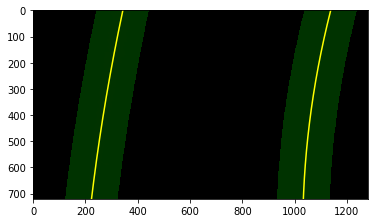

In [152]:
left_fit, right_fit,left_lane_inds, right_lane_inds, nonzerox, nonzeroy = locate_lines(warped_img) 
visulizeLanes(left_fit, right_fit, left_lane_inds, right_lane_inds, warped_img, nonzerox, nonzeroy, margin = 100,save_image ="False",project_id=1)

2.3 Radius Of Curvature

In [143]:
def radius_curvature(binary_warped, left_fit, right_fit):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curvature =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5) / np.absolute(2*left_fit_cr[0])
    right_curvature = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Calculate vehicle center
    #left_lane and right lane bottom in pixels
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    
    # Lane center as mid of left and right lane bottom                        
    lane_center = (left_lane_bottom + right_lane_bottom)/2.
    center_image = 640
    center = (lane_center - center_image)*xm_per_pix #Convert to meters
    position = "left" if center < 0 else "right"
    center = "Vehicle is {:.2f}m {}".format(center, position)
    
    # Now our radius of curvature is in meters
    return left_curvature, right_curvature, center


In [144]:
left_curvature, right_curvature, center = radius_curvature(warped_img, left_fit, right_fit)

2.4 Drawing Lanes on Image

In [145]:
def draw_on_image(undist, warped_img, left_fit, right_fit, M, left_curvature, right_curvature, center, show_values = True,project_id=1):
    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    Minv = np.linalg.inv(M)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    cv2.putText(result, 'Left curvature: {:.0f} m'.format(left_curvature), (50, 50), cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, 'Right curvature: {:.0f} m'.format(right_curvature), (50, 100), cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, '{}'.format(center), (50, 150), cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 255, 255), 2)
    if show_values == True:
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.imshow(result)
        if(project_id==1):
            cv2.imwrite('output_images/Project_Video_Outputs/LaneDrawnImage_test1.jpg',result)
        elif(project_id==2):
            cv2.imwrite('output_images/Challenge_Video_Outputs/LaneDrawnImage_test1.jpg',result)
        else:
            cv2.imwrite('output_images/Harder_Challenge_Video_Outputs/LaneDrawnImage.jpg',result)        
    return result

array([[[117, 159, 199],
        [117, 159, 199],
        [117, 159, 199],
        ..., 
        [ 82, 140, 186],
        [ 83, 140, 187],
        [ 84, 140, 187]],

       [[117, 159, 199],
        [117, 159, 199],
        [117, 159, 199],
        ..., 
        [ 82, 140, 186],
        [ 83, 140, 186],
        [ 84, 140, 187]],

       [[117, 159, 199],
        [117, 159, 199],
        [117, 159, 199],
        ..., 
        [ 82, 140, 186],
        [ 82, 139, 186],
        [ 83, 139, 186]],

       ..., 
       [[103,  87, 101],
        [103,  87, 100],
        [103,  87, 100],
        ..., 
        [113,  92,  89],
        [113,  92,  90],
        [114,  93,  90]],

       [[106,  88, 101],
        [107,  89, 101],
        [108,  90, 102],
        ..., 
        [115,  94,  91],
        [116,  95,  92],
        [117,  96,  93]],

       [[102,  85,  96],
        [102,  85,  95],
        [102,  85,  95],
        ..., 
        [116,  93,  89],
        [117,  94,  91],
        [119,  96,

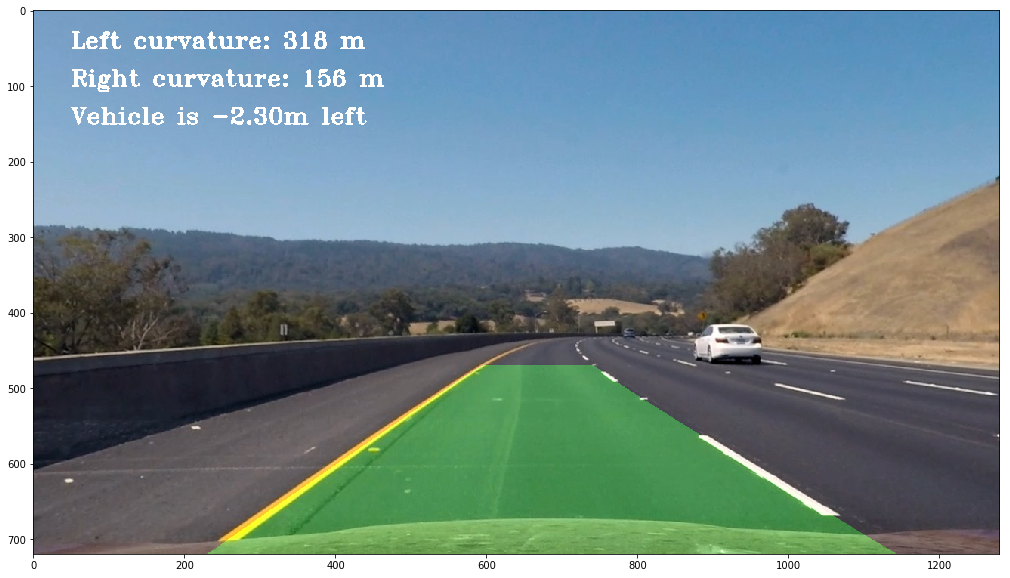

In [153]:
draw_on_image(test_image_output, warped_img, left_fit, right_fit, M, left_curvature, right_curvature, center, True,project_id=1)

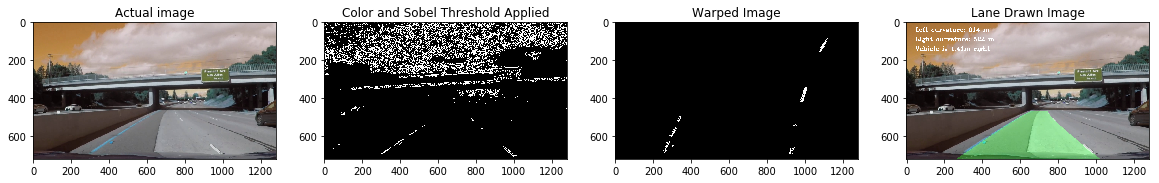

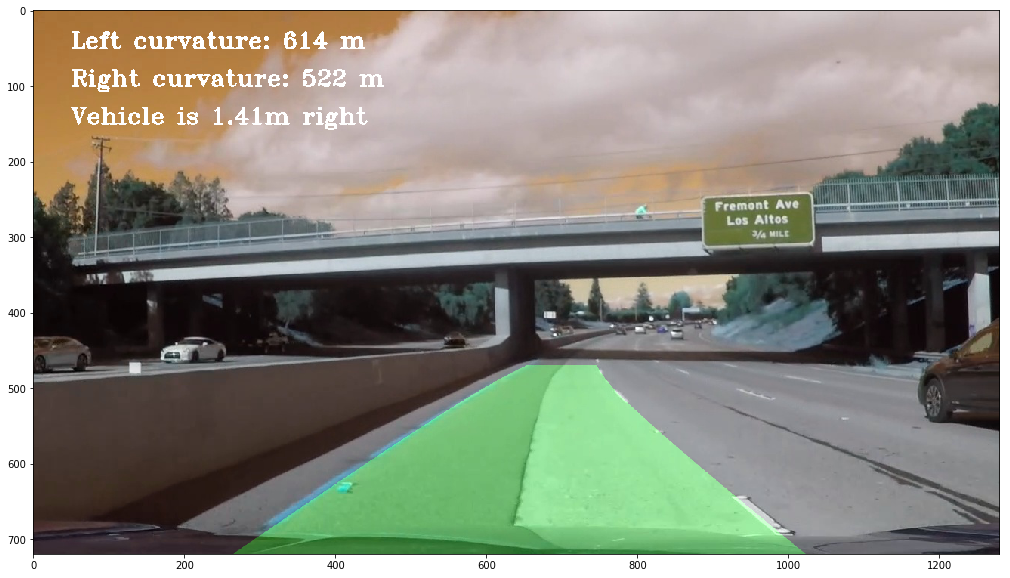

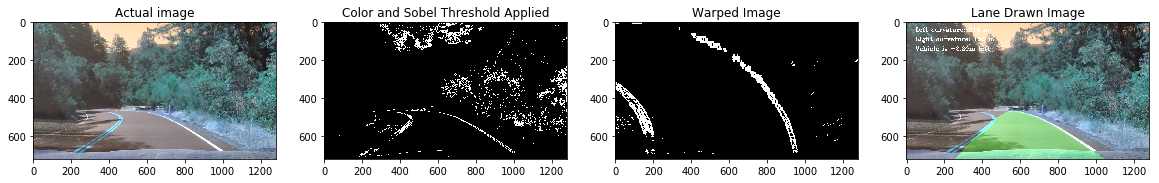

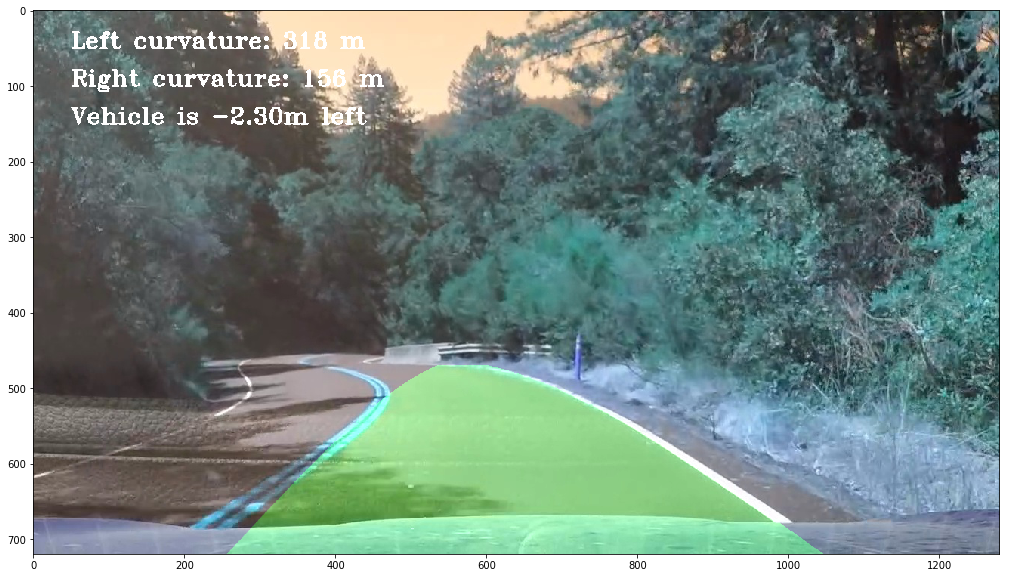

In [91]:
def AllStagesTogether_Images(image):
    test_image_output = undistort_image(image)
    Thresholded_Binary = color_Sobel_thresholder(test_image_output)
    warped_img, M = transform_image(Thresholded_Binary)
    left_fit, right_fit,left_lane_inds, right_lane_inds, nonzerox, nonzeroy = locate_lines(warped_img) 
    #visulizeLanes(left_fit, right_fit, left_lane_inds, right_lane_inds, warped_img, nonzerox, nonzeroy, margin = 100)
    left_curvature, right_curvature, center = radius_curvature(warped_img, left_fit, right_fit)

    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
    ax1.set_title('Actual image')
    ax1.imshow(image)
    ax2.set_title('Color and Sobel Threshold Applied')
    ax2.imshow(Thresholded_Binary, cmap='gray')
    ax3.set_title('Warped Image')
    ax3.imshow(warped_img,cmap='gray')
    ax4.set_title('Lane Drawn Image')
    ax4.imshow(draw_on_image(image, warped_img, left_fit, right_fit, M, left_curvature, right_curvature, center, True))

AllStagesTogether_Images(mpimg.imread('test_images/test_challenge_images1.jpg'))
AllStagesTogether_Images(mpimg.imread('test_images/test_harder_challenge_images1.jpg'))

# 3. Pipeline (Test videos)

In [160]:
def is_lane_valid(left_fit, right_fit):
    
    #Check if left and right fit returned a value
    if len(left_fit) ==0 or len(right_fit) == 0:
        status = False

    else:
        #Check distance b/w lines
        ploty = np.linspace(0, 20, num=10 )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        delta_lines = np.mean(right_fitx - left_fitx)
        if delta_lines >= 200 and delta_lines <=1500: 
            status = True
        else:
            status = False
        
        # Calculate slope of left and right lanes at 2/3rd point of y (i.e. 540)
        left = 2*left_fit[0]*540+left_fit[1]
        right = 2*right_fit[0]*540+right_fit[1]
        delta_slope_mid =  np.abs(left-right)
        #print("slope mid",delta_lines,delta_slope_mid,left,right)
        #Check if lines are parallel at the middle
        if delta_slope_mid <= 0.8:
            status = True
            # storing Slopes for last 10 frames to check curvy tracks
            #print(lane.slopes,lane.slope_counter)
            lane.slopes[lane.slope_counter] = delta_slope_mid
            if(lane.slope_counter<9):
                lane.slope_counter = lane.slope_counter+1
            else:
                lane.slope_counter=0
            #Checking for curvy tracks
            if(np.mean(lane.slopes)>0.5):                
                lane.curvyPath = True
            else:
                lane.curvyPath = False
        else:
            status = False
        #print("else case",status)
        if(delta_lines ==0.0) and (delta_slope_mid ==0.0):
            lane.counter=0
            lane.last_left = None
            lane.last_right = None
            lane.left_fit = None
            lane.right_fit = None

            lane.last_leftx = None
            lane.last_lefty = None
            lane.last_rightx = None
            lane.last_righty = None            
            
    return status

In [42]:
def find_lanes(img):
    img = undistort_image(img, mtx, dist)
    combined_binary = color_Sobel_thresholder(img)
    warped_img, M = transform_image(combined_binary) 
    if lane.counter == 0:
        lane.left_fit, lane.right_fit,left_lane_inds, right_lane_inds, nonzerox, nonzeroy = locate_lines(warped_img)
    else:
        lane.left_fit, lane.right_fit  = locate_line_further(lane.left_fit, lane.right_fit, warped_img)
    
    #Sanity check
    status = is_lane_valid(lane.left_fit, lane.right_fit)
    
    if status == True:        
        lane.last_left, lane.last_right = lane.left_fit, lane.right_fit        
        lane.counter += 1
        lane.reset_counter = 0
    else:   
        #Reset
        if lane.reset_counter > 4:
            lane.left_fit, lane.right_fit,left_lane_inds, right_lane_inds, nonzerox, nonzeroy = locate_lines(warped_img)
            lane.reset_counter = 0
            lane.counter = 0
        else:
            lane.left_fit, lane.right_fit = lane.last_left, lane.last_right
            
        lane.reset_counter += 1
    
    return warped_img, lane.left_fit, lane.right_fit, M


def pipeline_video(img, show_values=False):
    warped_img, left_fit, right_fit, M = find_lanes(img)
    left_curvature, right_curvature, center = radius_curvature(warped_img, left_fit, right_fit)
    
    return draw_on_image(img, warped_img, left_fit, right_fit, M, left_curvature, right_curvature, center, show_values)

In [43]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Project Video Test

In [46]:
countere=30
lane = LaneFinder()
def process_image(img):
    cv2.imwrite('test_images/test_challenge_Error_Image.jpg',img)
    global countere
    #print(countere)
    if(countere<30) and (countere%2):
        cv2.imwrite('test_images/test_challenge_images2_'+ str(countere)+'.jpg',img)
    countere = countere +1    
    return pipeline_video(img)
    #return warped_img

white_output = 'test_videos_output/project_video_final.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video_final.mp4
[MoviePy] Writing video test_videos_output/project_video_final.mp4



 12%|█▏        | 152/1261 [03:16<24:10,  1.31s/it]


 24%|██▍       | 303/1261 [06:34<20:42,  1.30s/it]


 36%|███▌      | 454/1261 [09:52<17:31,  1.30s/it]


 48%|████▊     | 605/1261 [13:12<14:23,  1.32s/it]


 60%|█████▉    | 756/1261 [16:31<11:00,  1.31s/it]


 72%|███████▏  | 907/1261 [19:47<07:37,  1.29s/it]


 84%|████████▍ | 1057/1261 [23:07<04:32,  1.34s/it]


 96%|█████████▌| 1205/1261 [26:24<01:14,  1.33s/it]


100%|█████████▉| 1260/1261 [27:36<00:01,  1.32s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_final.mp4 

CPU times: user 24min 47s, sys: 29.8 s, total: 25min 17s
Wall time: 27min 39s


In [47]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Challenge Video Test

In [163]:
lane.last_left = None
lane.last_right = None
lane.left_fit = None
lane.right_fit = None

lane.last_leftx = None
lane.last_lefty = None
lane.last_rightx = None
lane.last_righty = None

lane.counter = 0
lane.reset_counter = 0

lane.slopes = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
lane.slope_counter=0
lane.curvyPath = False

white_output = 'test_videos_output/challenge_video_final.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_video_final.mp4
[MoviePy] Writing video test_videos_output/challenge_video_final.mp4



 32%|███▏      | 155/485 [03:15<07:05,  1.29s/it]


 64%|██████▎   | 309/485 [06:33<03:43,  1.27s/it]


 95%|█████████▌| 463/485 [09:51<00:28,  1.28s/it]


100%|██████████| 485/485 [10:19<00:00,  1.28s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video_final.mp4 

CPU times: user 9min 27s, sys: 1.42 s, total: 9min 29s
Wall time: 10min 22s


In [164]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Harder Challenge Video Test

In [161]:
lane.last_left = None
lane.last_right = None
lane.left_fit = None
lane.right_fit = None

lane.last_leftx = None
lane.last_lefty = None
lane.last_rightx = None
lane.last_righty = None

lane.counter = 0
lane.reset_counter = 0
lane.slopes = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
lane.slope_counter=0
lane.curvyPath = False

white_output = 'test_videos_output/harder_challenge_video_final.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4").subclip(0,30)
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/harder_challenge_video_final.mp4
[MoviePy] Writing video test_videos_output/harder_challenge_video_final.mp4



 21%|██        | 155/751 [03:22<13:06,  1.32s/it]


 41%|████      | 309/751 [06:48<10:11,  1.38s/it]


 62%|██████▏   | 463/751 [10:17<06:29,  1.35s/it]


 82%|████████▏ | 617/751 [13:39<02:55,  1.31s/it]


100%|█████████▉| 750/751 [16:38<00:01,  1.38s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/harder_challenge_video_final.mp4 

CPU times: user 14min 56s, sys: 2.27 s, total: 14min 58s
Wall time: 16min 42s


In [162]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))